In [1]:
from IPython.core.display import HTML, display
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_1185/1410932729.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import logging
import pytorch_lightning as pl
import warnings

warnings.filterwarnings('ignore')
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

## Data load

In [3]:
! mkdir ../../data
! curl -OL https://storage.googleapis.com/di-datasets/age-prediction-nti-sbebank-2019.zip
! unzip -j -o age-prediction-nti-sbebank-2019.zip 'data/*.csv' -d ../../data
! mv age-prediction-nti-sbebank-2019.zip ../../data/

mkdir: cannot create directory ‘../../data’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  239M  100  239M    0     0   141M      0  0:00:01  0:00:01 --:--:--  141M
Archive:  age-prediction-nti-sbebank-2019.zip
  inflating: ../../data/test.csv     
  inflating: ../../data/small_group_description.csv  
  inflating: ../../data/train_target.csv  
  inflating: ../../data/transactions_train.csv  
  inflating: ../../data/transactions_test.csv  


## Data Preproccessing

In [4]:
import os
import pandas as pd
import numpy as np


data_path = '../../data/'

# Load train dataframe:

train_source_df = pd.read_csv(os.path.join(data_path, 'transactions_train.csv'))
print('Number of train samples:', len(train_source_df))
print('Number of unique clients in train:', len(np.unique(train_source_df['client_id'])))
print()

# Load test dataframe:

test_source_df = pd.read_csv(os.path.join(data_path, 'transactions_test.csv'))
print('Number of test samples:', len(test_source_df))
print('Number of unique clients in test:', len(np.unique(test_source_df['client_id'])))

Number of train samples: 26450577
Number of unique clients in train: 30000

Number of test samples: 17667328
Number of unique clients in test: 20000


In [5]:
train_source_df.head(2)

,client_id,trans_date,small_group,amount_rur
0,33172,6,4,71.463
1,33172,6,35,45.017


In [6]:
test_source_df.head(2)

,client_id,trans_date,small_group,amount_rur
0,46445,3,0,19.555
1,46445,3,1,27.774


In [7]:
# In case train data has targets and test data has not we will use full test data
# for unsupervised metric learning to obtain pretrained encoder. The train data
# with targets we will use for finetuning the encoder in a supervised manner and testing

df_target = pd.read_csv(os.path.join(data_path, 'train_target.csv'))
df_target.set_index('client_id', inplace=True)
df_target.rename(columns={"bins": "target"}, inplace=True)
df_target.head(5)

,target
client_id,
24662,2
1046,0
34089,2
34848,1
47076,3


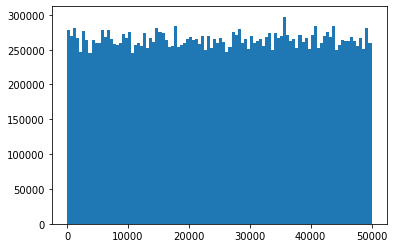

In [8]:
import matplotlib.pyplot as plt


# Look at distribution of client_id in train_df:

plt.hist(train_source_df['client_id'], bins=100)
plt.show()

In [9]:
# Split train_df into finetuning and testing parts:

finetuning_df = train_source_df[train_source_df['client_id'] < 40000]
test_df = train_source_df[train_source_df['client_id'] >= 40000]
print(len(finetuning_df))
print(len(test_df))
print('Test ratio:', round(len(test_df) / (len(test_df) + len(finetuning_df)), 2))

21146663
5303914
Test ratio: 0.2


In [10]:
from dltranz.data_preprocessing import PandasDataPreprocessor

preprocessor = PandasDataPreprocessor(
    col_id='client_id',
    cols_event_time='trans_date',
    time_transformation='float',
    cols_category=["trans_date", "small_group"],
    cols_log_norm=["amount_rur"],
    col_target=["target"],
    print_dataset_info=False,
)

In [11]:
%%time


# Fit preprocessor on all data except test_df:
full_source_train_df = pd.concat([test_source_df, finetuning_df])
preproc_fitted = preprocessor.fit(full_source_train_df)

dataset_metric_learn = preproc_fitted.transform(test_df)
dataset_finetuning = preproc_fitted.transform(finetuning_df)
dataset_testing = preproc_fitted.transform(test_df)
# full_source_train = dataset_finetuning + dataset_testing

print('Clients in MetricLearn dataset:', len(dataset_metric_learn))
print('Clients in FineTuning dataset:', len(dataset_finetuning))
print('Clients in Testing dataset:', len(dataset_testing))

Clients in MetricLearn dataset: 6023
Clients in FineTuning dataset: 23977
Clients in Testing dataset: 6023
CPU times: user 1min 22s, sys: 13.8 s, total: 1min 35s
Wall time: 1min 35s


In [12]:
# Add targets to dataset_finetuning and dataset_testing:

print(dataset_finetuning[0].keys())

for el in dataset_finetuning:
    el['target'] = df_target['target'][el['client_id']]
for el in dataset_testing:
    el['target'] = df_target['target'][el['client_id']]

print(dataset_finetuning[0].keys())

dict_keys(['client_id', 'trans_date', 'small_group', 'amount_rur', 'event_time'])
dict_keys(['client_id', 'trans_date', 'small_group', 'amount_rur', 'event_time', 'target'])


## Embedding training

Model training in our framework organised via pytorch-lightning (pl) framework.
The key parts of neural networks training in pl are: 

    * model (pl.LightningModule)
    * data_module (pl.LightningDataModule)
    * pl.trainer (pl.trainer)
    
For futher details check https://www.pytorchlightning.ai/

### model 

In [13]:
from dltranz.seq_encoder import SequenceEncoder
from dltranz.models import Head
from dltranz.lightning_modules.emb_module import EmbModule

seq_encoder = SequenceEncoder(
    category_features=preprocessor.get_category_sizes(),
    numeric_features=["amount_rur"],
    trx_embedding_noize=0.003
)

head = Head(input_size=seq_encoder.embedding_size, use_norm_encoder=True)

model = EmbModule(seq_encoder=seq_encoder, head=head)

### Data module

In [14]:
from dltranz.data_load.data_module.emb_data_module import EmbeddingTrainDataModule

dm = EmbeddingTrainDataModule(
    dataset=dataset_metric_learn,
    pl_module=model,
    min_seq_len=25,
    seq_split_strategy='SampleSlices',
    category_names = model.seq_encoder.category_names,
    category_max_size = model.seq_encoder.category_max_size,
    split_count=6,
    split_cnt_min=25,
    split_cnt_max=200,
    train_num_workers=0,
    train_batch_size=256,
    valid_num_workers=0,
    valid_batch_size=256
)

### Trainer Metric Learning

In [15]:
import torch
import pytorch_lightning as pl
import logging


# logging.getLogger("lightning").addHandler(logging.NullHandler())
# logging.getLogger("lightning").propagate = False


trainer_ML = pl.Trainer(
#     progress_bar_refresh_rate=0,
    max_epochs=150,
    gpus=1 if torch.cuda.is_available() else 0
)

### Training Metric Learning

In [37]:
%%time

trainer_ML.fit(model, dm)

## FineTuning

### model

In [30]:
import copy
from dltranz.seq_to_target_demo import SeqToTargetDemo


pretrained_encoder = copy.deepcopy(model.seq_encoder)

downstream_model = SeqToTargetDemo(pretrained_encoder,
                                   encoder_lr=0.0001,
                                   in_features=model.seq_encoder.embedding_size,
                                   out_features=4,
                                   head_lr=0.02,
                                   weight_decay=0.0,
                                   lr_step_size=10,
                                   lr_step_gamma=0.2)

### Data module

In [31]:
from dltranz.data_load.data_module.seq_to_target_data_module import SeqToTargetDatamodule


finetune_dm = SeqToTargetDatamodule(dataset=dataset_finetuning, pl_module=downstream_model)

### Trainer FineTuning

In [32]:
trainer_FT = pl.Trainer(
#     progress_bar_refresh_rate=0,
    max_epochs=40,
    gpus=1 if torch.cuda.is_available() else 0
)

### Training FineTuning

In [38]:
trainer_FT.fit(downstream_model, finetune_dm)

### Testing

In [37]:
from torch.utils.data import DataLoader
from dltranz.data_load import padded_collate


test_dataset = list(finetune_dm.post_proc(iter(dataset_testing)))

test_dataloader = DataLoader(dataset=test_dataset,
                             collate_fn=padded_collate,
                             num_workers=0,
                             batch_size=128)


trainer_FT.test(dataloaders=test_dataloader)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.6368919014930725}
--------------------------------------------------------------------------------


[{'test_accuracy': 0.6368919014930725}]